<a target="_blank" href="https://colab.research.google.com/github/trainocate-japan/Machine-Learning-and-Deep-Learning-Hands-on/blob/main/answer/7_CNNによる画像分類/7-2_PyTorchによる画像分類.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 7-2_PyTorchによる画像分類
このノートブックではPyTorchを用いて画像分類を行うモデルを作成します。<br>
テーマはMNISTという手書きの数字を0～9のどれなのかを判別するものです。

画像データを分類する場合には、画像を同じサイズに準備したり、ラベル付けの作業を事前に行っておく必要がありますが、今回はデータセットとしてすでに用意してあります。また、これまでの構造化データとは違い、説明変数は画像の各ピクセルのみです。データの範囲や説明変数の数はすでに分かっているので、データについて詳細に確認する作業は省略し、必要な作業に絞ってプログラミングしていきます。

## ランタイムをGPUに切り替える
画像分類では非常に多くのコンピューティングリソースを使うため、CPUではとても時間がかかってしまいます。
そこで、Google ColaboratoryのランタイムをGPUに切り替えます。

ランタイムをGPUに切り替えるには、上部のメニューから「ランタイム > ランタイムのタイプを変更」を選択し、ハードウェアアクセラレーターでGPUを選択して、保存をクリックします。

Kerasの場合は自動的にランタイムを判断して、GPUが使用できる場合にはGPUを使用して演算を行いますが、PyTorchでは、別途GPUを使うためのプログラミングが必要です。

## ライブラリのインポート

In [1]:
# データを処理するための基本的なライブラリ
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# データセット用
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# PyTorchで使用
import torch

#### GPUチェック

In [2]:
# GPUが使用できることを確認する。「cuda」がGPUのことで、これが見つかった場合はcuda:0と表示させる
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## データの準備

#### Transformsによるデータの前処理
PyTorchにはデータ変換を定義することで、datasetにする際に自動でデータ変換を行ってくれるTransforms機能があります。

torchvisionに含まれるデータセットを使用する場合には、ダウンロードと共にTransformsで変換しつつdatasetにすることができるので大変便利です。

今回はtorchvisionからデータをダウンロードするので、この機能を利用してデータをtorchtensorに変換します。

また、Transformsを使用してデータのスケールを変更することもできます。今回はすでにデータが0～1の範囲で正規化されているため、この作業は行いません。

In [3]:
# データ変換用関数 Transforms
transform = transforms.Compose([
    # データのテンソル化
    transforms.ToTensor(),
])

In [4]:
# データ取得用関数 Dataset

# 訓練用データセットの定義
train_set = datasets.MNIST(
    root = './data', # ダウンロード先ディレクトリ名 
    train = True,
    download = True,
    transform = transform)

# 検証データセットの定義
val_set = datasets.MNIST(
    root = './data', 
    train = False, 
    download = True, 
    transform = transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## モデルの定義
- モデルの概要
  - 畳み込み層(16チャネル)
    - 畳み込みカーネル 5×5
    - パディングにより畳み込み後にサイズを小さくしない
    - 活性化関数はReLUを使用（カーネル通過後の特徴をより際立たせる）
  -プーリング層(16チャネル)
    - マックスプーリング 2×2
  - 全結合層(1024)
  - 出力層(10)


In [5]:
# 乱数の固定化
torch.manual_seed(123)
torch.cuda.manual_seed(123) # GPUのための乱数固定

# モデルの定義

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 畳み込み層
        # 引数は順番に「入力チャネル数」「出力チャネル数」「畳み込みカーネルの一辺のサイズ」
        # paddingオプションで入力画像の外側に縦横2ピクセルのパディングを行い、畳み込み後も画像サイズを維持する。
        self.conv = torch.nn.Conv2d(1, 16, 5, padding=(2,2))
        # 活性化関数ReLU
        self.relu = torch.nn.ReLU(inplace=True)
        self.dropout1 = torch.nn.Dropout(0.3)
        # プーリング層
        self.maxpool = torch.nn.MaxPool2d((2,2))
        # 全結合層
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(3136, 1024)
        # forward定義時にここにReLUを挟む
        self.dropout2 = torch.nn.Dropout(0.3)
        self.linear2 = torch.nn.Linear(1024, 10)
   
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.linear2(x)
        return x

# 後で設定するPyTorchのCrossEntropyLossは、softmax関数を内包するような損失関数になっています。
# そのため、Softmax関数を最後に入れる必要がありません。
# ただし、確率値を求めたい場合には予測値にsoftmax関数を用いる必要があります。

## 学習

In [8]:
num_epochs = 10

# データローダーの用意
batch_size = 256
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = False)

# モデルをインスタンス化
net = Net()
net = net.to(device) # ★モデルをGPU側に送る。GPUを使用する場合に必要
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

## 学習に必要な空リストを作成
train_loss_list = []#学習損失
train_accuracy_list = []#学習データ正解率
val_loss_list = []#評価損失
val_accuracy_list = []#検証データの正答率

for epoch in range(num_epochs):
    
    #学習の進行状況を表示
    print('--------')
    print("Epoch: {}/{}".format(epoch + 1, num_epochs))

    #損失と正解率の初期化
    train_loss = 0      #学習損失
    train_accuracy = 0  #学習データの正答数
    val_loss = 0        #評価損失
    val_accuracy = 0    #検証データの正答数

    #学習モードに設定
    net.train()

    #ミニバッチごとにデータをロードして学習
    for x, y in train_dataloader:
        
        # GPUヘ転送
        x = x.to(device)
        y = y.to(device)

        preds = net(x)
        predlabels = torch.max(preds, 1)[1] # 予測ラベル導出
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #ミニバッチごとの損失と精度を備蓄
        train_loss += loss.item()
        train_accuracy += (y == predlabels).sum() / batch_size
    
    #ミニバッチの平均の損失と正解率を計算
    batch_train_loss = train_loss / len(train_dataloader)
    batch_train_accuracy = train_accuracy / len(train_dataloader)

    #評価モードに設定
    net.eval()
    #評価時に自動微分をゼロにする
    with torch.no_grad():
        for x, y in val_dataloader:

            # GPUヘ転送
            x = x.to(device)
            y = y.to(device)

            #データを入力して予測値を計算
            preds = net(x)
            predlabels = torch.max(preds, 1)[1] # 予測ラベル導出
            #損失を計算
            loss = criterion(preds, y)
            #ミニバッチごとの損失と精度を備蓄
            val_loss += loss.item()
            val_accuracy += (y == predlabels).sum() / batch_size

    #ミニバッチの平均の損失と正解率を計算
    batch_val_loss = val_loss / len(val_dataloader)
    batch_val_accuracy = val_accuracy / len(val_dataloader)
    #エポックごとに損失と正解率を表示
    print("Train_Loss: {:.4f} Train_Accuracy: {:.4f}".format(batch_train_loss, batch_train_accuracy))
    print("Val_Loss: {:.4f} Val_Accuracy: {:.4f}".format(batch_val_loss, batch_val_accuracy))
    #損失と正解率をリスト化して保存
    train_loss_list.append(batch_train_loss)
    #train_accuracy_list.append(batch_train_accuracy)
    train_accuracy_list.append(batch_train_accuracy.cpu())
    val_loss_list.append(batch_val_loss)
    #val_accuracy_list.append(batch_val_accuracy)
    val_accuracy_list.append(batch_val_accuracy.cpu())

--------
Epoch: 1/10
Train_Loss: 0.2639 Train_Accuracy: 0.9193
Val_Loss: 0.1066 Val_Accuracy: 0.9491
--------
Epoch: 2/10
Train_Loss: 0.0802 Train_Accuracy: 0.9739
Val_Loss: 0.0594 Val_Accuracy: 0.9590
--------
Epoch: 3/10
Train_Loss: 0.0558 Train_Accuracy: 0.9801
Val_Loss: 0.0537 Val_Accuracy: 0.9608
--------
Epoch: 4/10
Train_Loss: 0.0426 Train_Accuracy: 0.9838
Val_Loss: 0.0391 Val_Accuracy: 0.9635
--------
Epoch: 5/10
Train_Loss: 0.0344 Train_Accuracy: 0.9866
Val_Loss: 0.0352 Val_Accuracy: 0.9653
--------
Epoch: 6/10
Train_Loss: 0.0285 Train_Accuracy: 0.9878
Val_Loss: 0.0314 Val_Accuracy: 0.9663
--------
Epoch: 7/10
Train_Loss: 0.0230 Train_Accuracy: 0.9902
Val_Loss: 0.0375 Val_Accuracy: 0.9636
--------
Epoch: 8/10
Train_Loss: 0.0193 Train_Accuracy: 0.9909
Val_Loss: 0.0337 Val_Accuracy: 0.9653
--------
Epoch: 9/10
Train_Loss: 0.0163 Train_Accuracy: 0.9922
Val_Loss: 0.0303 Val_Accuracy: 0.9663
--------
Epoch: 10/10
Train_Loss: 0.0163 Train_Accuracy: 0.9918
Val_Loss: 0.0336 Val_Accura

## 評価

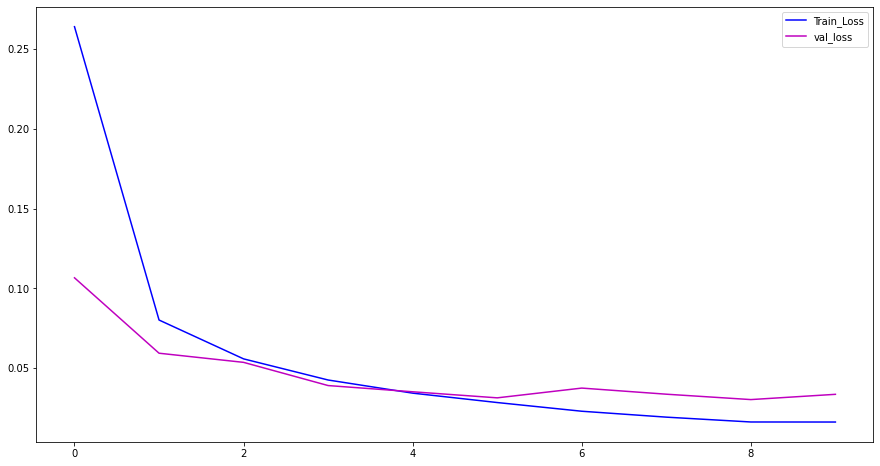

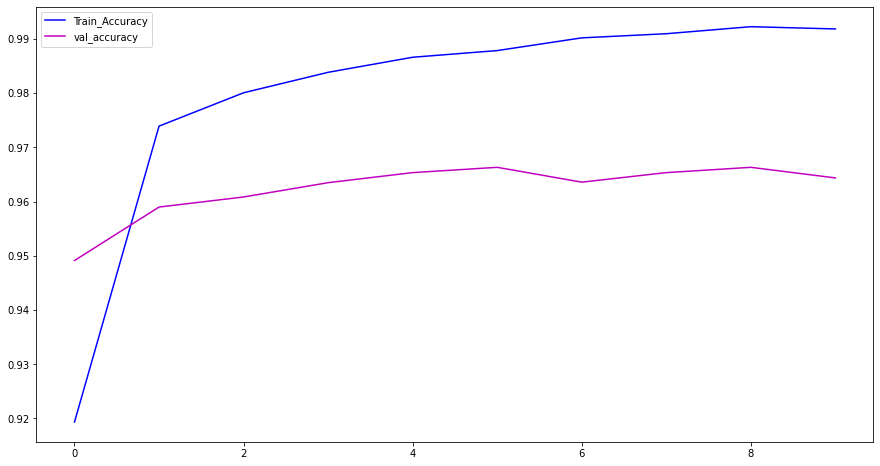

In [9]:
# 損失関数
plt.figure(figsize=(15, 8))
plt.plot(train_loss_list, color='b', label='Train_Loss')
plt.plot(val_loss_list, color='m', label='val_loss')
plt.legend()

# 精度
plt.figure(figsize=(15, 8))
plt.plot(train_accuracy_list, color='b', label='Train_Accuracy')
plt.plot(val_accuracy_list, color='m', label='val_accuracy')
plt.legend()

plt.show()

(参考)予測をしてみる

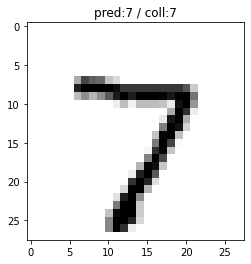

In [10]:
# 検証データn番目の画像で予測してみる
n = 0

# モデルを評価モードにする
net.eval()

y_pred = None
images = None
labels = None

# 検証用データローダからデータを一つのバッチだけ取り出す
with torch.no_grad():
  for x, y in val_dataloader:
    images = x
    labels = y
    break

# 予測を実行する
images = images.to(device)
pred = net(images)
pred =pred.to('cpu').detach().numpy().copy()
prediction = np.argmax(pred, axis=1)

# 画像をnumpyに直して表示できるようにしておく
images = images.to('cpu').detach().numpy().copy()

plt.title(f'pred:{prediction[n]} / coll:{labels[n]}')   # ラベルを設定
plt.imshow(images[n].reshape((28, 28)), vmin=0, vmax=1, cmap=plt.cm.gray_r) # 画像を表示
plt.show()